In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, RandomWalkKernel


import sys
sys.path.append("../../../")
from LRM.plotting import set_plot_style
from LRM.IsingModel import IsingModel

from matplotlib import cm
set_plot_style()


In [5]:
#NOTE: ---- Grid and Simulation ----

def initialize_grid(size):
    return np.random.choice([-1, 1], size=(size, size))

def get_neighbors(grid, i, j):
    top = grid[(i - 1) % grid.shape[0], j]
    bottom = grid[(i + 1) % grid.shape[0], j]
    left = grid[i, (j - 1) % grid.shape[1]]
    right = grid[i, (j + 1) % grid.shape[1]]
    return [top, bottom, left, right]

def energy(spin, neighbors, T, m):
    return - T * spin * sum(neighbors) - m * spin

def update_spin(grid, i, j, T, m):
    neighbors = get_neighbors(grid, i, j)
    e_pos = energy(+1, neighbors, T, m)
    e_neg = energy(-1, neighbors, T, m)

    max_e = max(-e_pos, -e_neg)
    p_pos = np.exp(-e_pos - max_e)
    p_neg = np.exp(-e_neg - max_e)
    prob_pos = p_pos / (p_pos + p_neg)

    grid[i, j] = 1 if np.random.rand() < prob_pos else -1

def simulate_ising(grid, T=0.33, m=0, iterations=100000, record_every=1000):
    size = grid.shape[0]
    mags = []
    for step in range(iterations):
        i, j = np.random.randint(size), np.random.randint(size)
        update_spin(grid, i, j, T, m)
        if step % record_every == 0:
            mags.append(np.mean(grid))
    return grid, mags

# Runtime and Parameter Estimates

In [15]:
size = 100
iterations = 2_000_000

prior_mean = np.array([0.5, 0.5]).reshape(-1, 1)
prior_cov  = 2 * np.eye(2)

# True parameters
true_T = 0.3
true_m = 0.15

# True parameters
"""true_T = 0.1
true_m = 0.05"""

np.random.seed(38)

# -------- Simulate --------
grid = initialize_grid(size)
grid, _ = simulate_ising(grid, T=true_T, m=true_m, iterations=iterations)
grid_t = torch.from_numpy(grid).to(torch.float32)

In [16]:
# -------- Log-Ratio (LRM) --------
mus, covs = [], []
for alpha in [0.1, 0.5, 1.0]:

    ising = IsingModel(grid_t.numpy(), alpha=alpha)
    beta_star, cov_star, res = ising.fit_coverage(
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        verbose=False,
    )
    mu_post, cov_post = ising.posterior(beta=beta_star, prior_mean=prior_mean, prior_cov=prior_cov)
    mus.append(mu_post), covs.append(cov_post)

# Plotting

In [17]:
import seaborn as sns
from scipy.stats import chi2, norm
from matplotlib.patches import Ellipse, Patch

def _ellipse_params_from_cov(mu, Sigma, q):
    """
    For 2x2 Sigma and center mu, return (width, height, angle_degrees)
    for the ellipse corresponding to (x-mu)^T Sigma^{-1} (x-mu) = q.
    q is typically a chi-square quantile with df=2 for probability mass p.
    """
    mu = np.asarray(mu, float).reshape(2)
    Sigma = np.asarray(Sigma, float).reshape(2, 2)
    # eigen-decomposition (ascending), sort to ensure major/minor axes
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    # ellipse radii along eigenvectors are sqrt(q * eigenvalue)
    width = 2.0 * np.sqrt(q * eigvals[0])
    height = 2.0 * np.sqrt(q * eigvals[1])
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    return float(width), float(height), float(angle)

def plot_gaussians_joint_marginals_filled_params(
    params,                 # list of (mu, Sigma)
    labels,                 # list[str], same length
    probs=(0.50, 0.80, 0.95),
    k_sigma=3.5,
    palette=None,           # seaborn palette or list of colors
    height=8,
    marginal_fill_alpha=0.35,
    ellipse_alpha_outer=0.18,
    ellipse_alpha_inner=0.38,
):
    """
    Plot multiple 2D Gaussians (given as (mu, Sigma)) with:
      • JOINT: nested filled probability ellipses at `probs` (no contour lines)
      • MARGINALS: filled 1D Normal PDFs on top/right axes

    Parameters
    ----------
    params : list[tuple[np.ndarray, np.ndarray]]
        Each item is (mu, Sigma) with mu shape (2,), Sigma shape (2,2).
    labels : list[str]
        One label per Gaussian.
    probs : iterable[float]
        Probability masses for the nested ellipses, e.g. (0.5, 0.8, 0.95).
    k_sigma : float
        Axis span heuristic (plot limits extend k_sigma * std in each direction).
    palette : str | list
        Seaborn palette name or explicit list of colors.
    height : float
        Seaborn JointGrid height in inches.
    marginal_fill_alpha : float
        Opacity for filled marginal PDFs.
    ellipse_alpha_outer : float
        Opacity for the largest-probability ellipse.
    ellipse_alpha_inner : float
        Opacity for the smallest-probability ellipse.

    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    if len(params) != len(labels):
        raise ValueError("`params` and `labels` must be the same length.")

    # Validate and collect
    mus, Sigmas = [], []
    for (mu, S) in params:
        mu = np.asarray(mu, float).reshape(2)
        S = np.asarray(S, float).reshape(2, 2)
        if not np.allclose(S, S.T):
            raise ValueError("Each covariance must be symmetric (2x2).")
        # Positive-definite check
        try:
            np.linalg.cholesky(S)
        except np.linalg.LinAlgError:
            raise ValueError("Covariance must be positive definite.")
        mus.append(mu)
        Sigmas.append(S)

    mus = np.stack(mus, axis=0)           # (N,2)
    Sigmas = np.stack(Sigmas, axis=0)     # (N,2,2)
    stds = np.sqrt(np.stack([np.diag(S) for S in Sigmas], axis=0))  # (N,2)

    # Global axis limits (across all dists)
    x_min = float(np.min(mus[:, 0] - k_sigma * stds[:, 0]))
    x_max = float(np.max(mus[:, 0] + k_sigma * stds[:, 0]))
    y_min = float(np.min(mus[:, 1] - k_sigma * stds[:, 1]))
    y_max = float(np.max(mus[:, 1] + k_sigma * stds[:, 1]))

    # Layout with seaborn
    g = sns.JointGrid(xlim=(x_min, x_max), ylim=(y_min, y_max), height=height, marginal_ticks=True)
    colors = ["cornflowerblue", "#4169E1", "#000080"]

    # Precompute chi^2 thresholds for requested probabilities (df=2)
    probs = tuple(sorted(probs))  # e.g. [0.5, 0.8, 0.95]
    chi2_levels = [chi2.ppf(p, df=2) for p in probs]
    # alpha ramp (outer -> inner)
    alphas = np.linspace(ellipse_alpha_outer, ellipse_alpha_inner, num=len(probs))

    legend_handles = []

    for color, label, mu, S in zip(colors, labels, mus, Sigmas):
        # JOINT: draw largest region first so smaller ones sit on top
        for q, a in zip(chi2_levels[::-1], alphas[::-1]):
            width, height_e, angle = _ellipse_params_from_cov(mu, S, q)
            e = Ellipse(
                xy=mu, 
                width=width,
                height=height_e,
                angle=angle,
                facecolor='none',
                edgecolor=color,
                linewidth=1.8,
                alpha=1.
            )
            g.ax_joint.add_patch(e)

        # MARGINALS: filled 1D normal PDFs
        sx, sy = np.sqrt(S[0, 0]), np.sqrt(S[1, 1])

        nx = 600
        ny = 600
        x = np.linspace(x_min, x_max, nx)
        y = np.linspace(y_min, y_max, ny)
        pdf_x = norm.pdf(x, loc=mu[0], scale=sx)
        pdf_y = norm.pdf(y, loc=mu[1], scale=sy)

        #g.ax_marg_x.fill_between(x, 0.0, pdf_x, facecolor=color, alpha=marginal_fill_alpha, linewidth=0)
        #g.ax_marg_y.fill_betweenx(y, 0.0, pdf_y, facecolor=color, alpha=marginal_fill_alpha, linewidth=0)

        g.ax_marg_x.plot(x, pdf_x, color=color, linewidth=1.8)
        g.ax_marg_y.plot(pdf_y, y, color=color, linewidth=1.8)

        legend_handles.append(Patch(facecolor=color, edgecolor='none', alpha=0.9, label=label))

    # Labels, legend, tidy spines
    g.ax_joint.set_xlabel(r"$\theta_1$")
    g.ax_joint.set_ylabel(r"$\theta_2$")
    g.ax_marg_x.set_ylabel("p(x)")
    g.ax_marg_y.set_xlabel("p(y)")
    g.ax_joint.legend(handles=legend_handles, frameon=False, loc="best")

    # Lines on the JOINT panel
    g.ax_joint.axhline(true_T, linestyle='--', linewidth=1, color='k', alpha=0.8)
    g.ax_joint.axvline(true_m, linestyle='--', linewidth=1, color='k', alpha=0.8)


    sns.despine(ax=g.ax_marg_x, left=False, bottom=False)
    sns.despine(ax=g.ax_marg_y, left=False, bottom=False)

    return g.fig


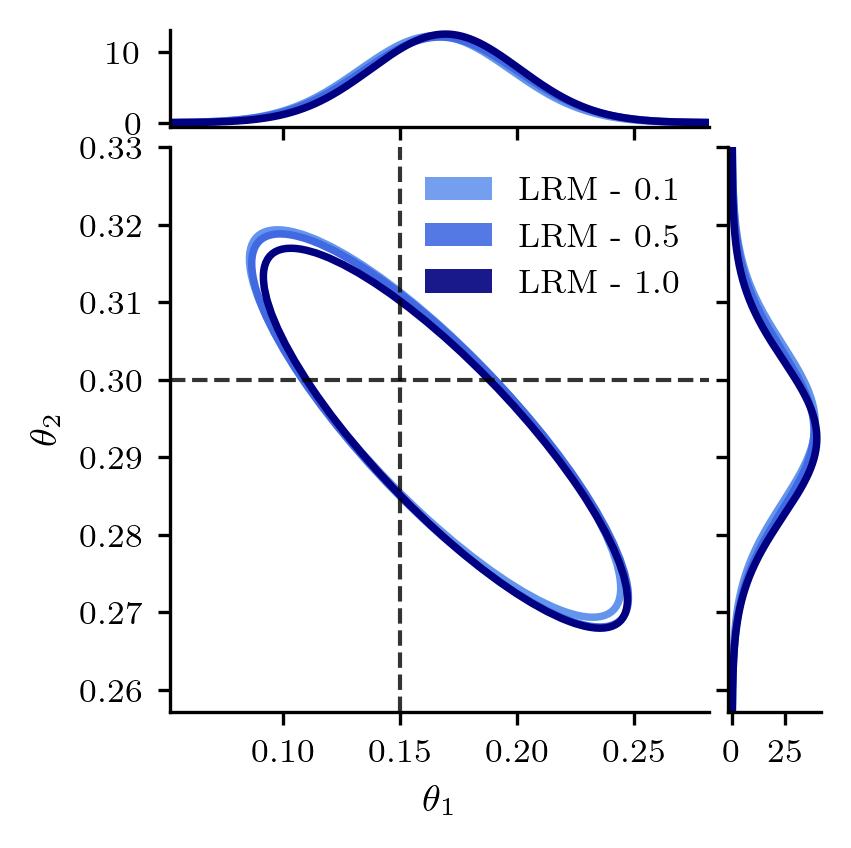

In [22]:
#dist_list = [(mu_post, cov_post), (mu_pl, cov_pl), (mu_dsm_1, cov_dsm_1), (mu_dsm_5, cov_dsm_5)]
#labels_list = ["LRM", "PL", r"DSM ($\beta=0.01$)", r"DSM ($\beta=0.05$)"]
#dist_list = [(mu_post, cov_post), (mu_pl, cov_pl), (mu_dsm_1, cov_dsm_1)]
dist_list = list(zip(mus, covs))
labels_list = labels_lisr = ["LRM - 0.1", "LRM - 0.5", "LRM - 1.0"]

fig = plot_gaussians_joint_marginals_filled_params(
    dist_list, labels_list,
    probs=(0.95,),  # 50%, 80%, 95% mass
    height=2.8
)

fig.savefig(f"./results/sensitivty-Ising-2d-param-posterior-theta1={true_m};theta2={true_T}.pdf", format='pdf', bbox_inches='tight')